# Pipelines de transformación de datos

Este es un cuaderno muy importante porque se introducen los *pipelines*; de momento sólo para transformar los datos.

Una de las características más importantes de este cuaderno es la utilización de clases para empaquetar los transformadores que actuarán sobre los datos.<br> Estas clases:
  - heredan de `BaseEstimator`  y `TransformerMixin`,
  - y deben implementar los métodos `fit` y `transform` (aunque pueden quedar vacíos)

---
    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2024, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2024, URJC (Spain)

    alfredo.cuesta@urjc.es


## Imports & carga de datos

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
#########################################################################

file_path = "../datasets/0vs1/"
file_name = "setX_0vs1.csv"
X_init = pd.read_csv(file_path+file_name, sep=';', header=None, dtype=int)
file_name = "setY_0vs1.csv"
Y_init = pd.read_csv(file_path+file_name, sep=';', header=None, dtype=int)

X_train_init, X_test_init, Y_train_init, Y_test_init = train_test_split(X_init, Y_init, test_size=0.33, 
                                                                        random_state=1234)

In [2]:
X_init.shape

(1000, 784)

## Creación de las clases donde se empaquetan los transformadores

In [3]:
class Pixels_to_Unit(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X/255.0


class ExtractFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, theta=0.1):
        self.theta = theta

    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        
        def fun_feat_extract(data, theta=0.3):
            # data: dataframe
            # theta: parameter of the feature extraction
            #
            features = np.zeros([data.shape[0], 8]) #<- allocate memory with zeros
            data = data.values.reshape([data.shape[0],28,28]) 
            #-> axis 0: id of instance, axis 1: width(cols) , axis 2: height(rows)
            for k in range(data.shape[0]):
                #..current image 
                x = data[k,:,:]
                #--width feature
                sum_cols = x.sum(axis=0) #<- axis0 of x, not of data!!
                indc = np.argwhere(sum_cols > theta * sum_cols.max())
                col_3maxs = np.argsort(sum_cols)[-3:] 
                features[k,0] = indc[-1][0] - indc[0][0]
                
                features[k,1:4] = col_3maxs
                #--width feature    
                sum_rows = x.sum(axis=1) #<- axis1 of x, not of data!!
                indr = np.argwhere(sum_rows > theta * sum_rows.max())
                features[k,4] = indr[-1][0] - indr[0][0]
                row_3maxs = np.argsort(sum_rows)[-3:] 
                features[k,5:8] = row_3maxs
            col_names = ['width','W_max1','W_max2','W_max3','height','H_max1','H_max2','H_max3']
            return pd.DataFrame(features,columns = col_names)  
    
        return fun_feat_extract(X, theta = self.theta)   
#---------------------------------------------------------------------------------------

class FeatureAreaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        
        def get_feat_area(features):
            values = features['width'] * features['height']
            return pd.DataFrame({'area':values})
        
        return get_feat_area(X)
    
#---------------------------------------------------------------------------------------

class FeatureWoverHTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self 

    def transform(self, X):

        def get_feat_WoverH(features):
            values = features['width'] / features['height']
            values = values.round(decimals=2)
            return pd.DataFrame({'WoverH':values})  

        return get_feat_WoverH(X)  

## Crear el pipeline

Un pipeline es una lista de tuplas donde el primer elemento de la tupla es un string con el nombre y el segundo elemento es un objeto capaz de transformar los datos de entrada. 

Hay dos tipos de pipelines: 
- Los que secuencian acciones para transformar las características se llaman **Pipeline**
- Los que paralelizan acciones para generar nuevas características son **FeatureUnion**

In [4]:
preprocess = []    #--------------

scaler1 = Pixels_to_Unit()
preprocess.append(('scaler1', scaler1))

theta = 0.1 #<-it ranges in [0,.5]
extractor = ExtractFeaturesTransformer(theta=theta)
preprocess.append( ('extractor', extractor) )
pipe1 = Pipeline(preprocess)

more_features = [] #--------------

poly_degree = 2
polyfeat = PolynomialFeatures(poly_degree).set_output(transform="pandas")
more_features.append( ('addPolyFeat', polyfeat) )
              
more_features.append( ('addArea', FeatureAreaTransformer()) )

more_features.append( ('addWoverH', FeatureWoverHTransformer()) )

pipe2 = FeatureUnion(more_features)

lastprocess = []  #--------------

scaler2 = MinMaxScaler().set_output(transform='pandas')
lastprocess.append( ('scaler2', scaler2) )

embedding_choice = 'lle' #<- 'isomap' , 'lle'
if embedding_choice == 'isomap':
    n_components = 2
    n_neighbors = 50
    metric = 'l1' #<-- 'cityblock', 'cosine', 'euclidean' , 'haversine' , 'l1' , 'l2' , 'manhattan' , 'nan_euclidean' 
    max_iter = 500
    lastprocess.append( 
        ('isomap',
         Isomap(n_neighbors=n_neighbors, n_components=n_components, metric=metric, 
                max_iter=max_iter).set_output(transform='pandas')) 
    )
elif embedding_choice == 'lle':
    n_components = 2
    n_neighbors = 40
    random_state = 1234
    max_iter = 200
    lastprocess.append((
        'lle',
         LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components,
                                max_iter=max_iter, random_state=random_state).set_output(transform='pandas') )
    )

pipe3 = Pipeline(lastprocess)

pipe = Pipeline([('pipe1',pipe1),('pipe2',pipe2),('pipe3',pipe3)])

pipe

Pipeline(steps=[('pipe1',
                 Pipeline(steps=[('scaler1', Pixels_to_Unit()),
                                 ('extractor', ExtractFeaturesTransformer())])),
                ('pipe2',
                 FeatureUnion(transformer_list=[('addPolyFeat',
                                                 PolynomialFeatures()),
                                                ('addArea',
                                                 FeatureAreaTransformer()),
                                                ('addWoverH',
                                                 FeatureWoverHTransformer())])),
                ('pipe3',
                 Pipeline(steps=[('scaler2', MinMaxScaler()),
                                 ('lle',
                                  LocallyLinearEmbedding(max_iter=200,
                                                         n_neighbors=40,
                                                         random_state=1234))]))])

## Aprender el pipeline de transformación con datos de entrada

Text(0.5, 1.0, 'Train data')

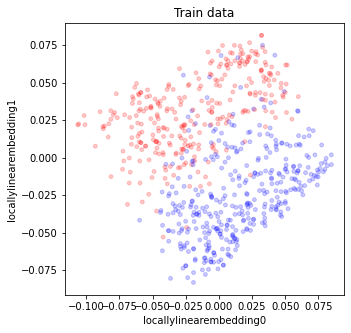

In [5]:
pipe.fit(X_train_init)
X_train = pipe.transform(X_train_init)
Y_color = Y_train_init.replace([0,1],['r','b']).values.ravel()
scatterplot = X_train.plot.scatter(x=X_train.columns[0],  y=X_train.columns[1],  c=Y_color, s=60, figsize=(5, 5), marker='.', alpha=.2)
scatterplot.set_title('Train data')

## Usar el pipeline aprendido para transformar el conjunto de test

In [6]:
X_test = pipe.transform(X_test_init)
X_test

,locallylinearembedding0,locallylinearembedding1
0,-0.033815,0.004112
1,0.074390,0.015859
2,-0.018664,0.035525
3,0.032781,0.045603
4,0.040248,0.043024
...,...,...
325,-0.056596,0.038543
326,0.057638,0.043289
327,0.024481,0.052816
328,0.023436,0.010582


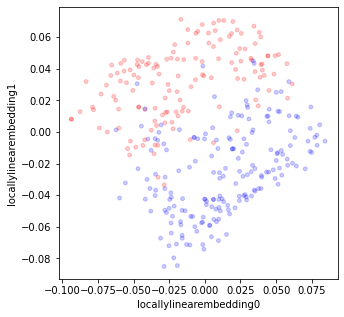

In [7]:
Y_color = Y_test_init.replace([0,1],['r','b']).values.ravel()
scatterplot = X_test.plot.scatter(x=X_test.columns[0],  y=X_test.columns[1],  c=Y_color, s=60, figsize=(5, 5), marker='.', alpha=.2)

## Guardar en un fichero CSV el resultado para cuadernos posteriores.

In [9]:
flag_save = False
if flag_save:
    Xtrain_filename = "Train_0vs1_2D.csv"
    Xtest_filename  = "Test_0vs1_2D.csv"
    X_train['target'] = Y_train_init.values.ravel()
    X_test['target']  = Y_test_init.values.ravel()
    X_train.to_csv(file_path+Xtrain_filename, sep=';', decimal='.', index=False)
    X_test.to_csv(file_path+Xtest_filename, sep=';', decimal='.', index=False)